# Importing Libraries

In [79]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark")
plt.style.use('dark_background')
print("Setup Complete")

Setup Complete


# Importing Dataset

In [80]:
machine_data = pd.read_csv("../input/machine-failure-predictions/machine failure.csv",index_col="UDI")
machine_data1 = pd.read_csv("../input/playground-series-s3e17/train.csv",index_col="id")
machine_data = machine_data.append(machine_data1)
machine_data.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


# Data Cleaning

In [81]:
from sklearn.preprocessing import LabelEncoder


machine_data.drop(["Product ID"],axis=1,inplace=True)
machine_data.columns = ['Type', 'Air_Temp_K', 'Process_Temp_K', 'Rot_Speed', 'Torque',
       'Tool_Wear', 'Machine_Failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
catDTypeCols = ['Type']

encoder = LabelEncoder()

machine_data["Type"] = encoder.fit_transform(machine_data["Type"])

machine_data.head()

,Type,Air_Temp_K,Process_Temp_K,Rot_Speed,Torque,Tool_Wear,Machine_Failure,TWF,HDF,PWF,OSF,RNF
1,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
2,1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
3,1,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
4,1,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
5,1,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


# Feature Engineering

In [82]:
machine_data["Temp_Diff"] = machine_data["Process_Temp_K"]-machine_data["Air_Temp_K"]
machine_data["Air_Temp_C"] = machine_data["Air_Temp_K"]-273
machine_data["Process_Temp_C"] = machine_data["Process_Temp_K"]-273
machine_data["Power"] = machine_data["Torque"]*machine_data["Rot_Speed"]

# EDA

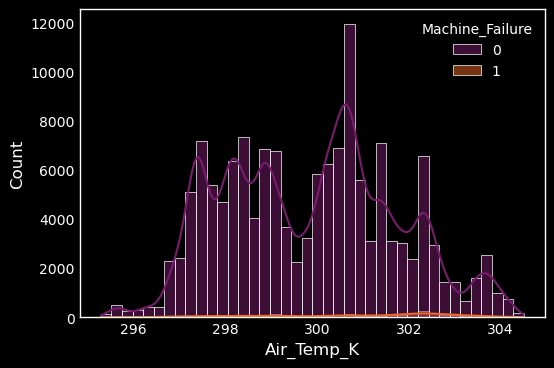

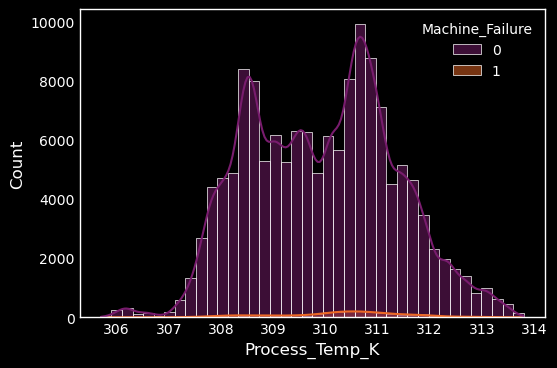

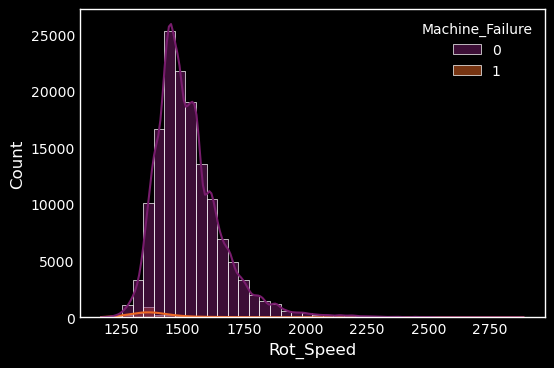

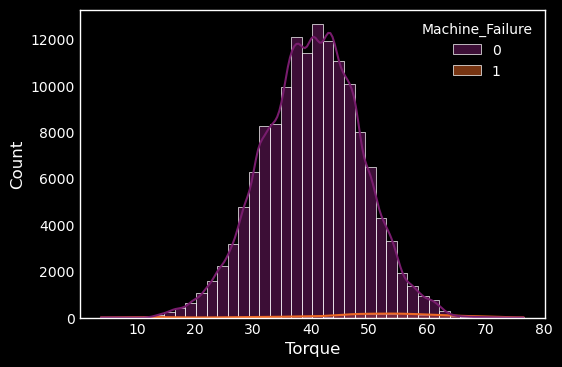

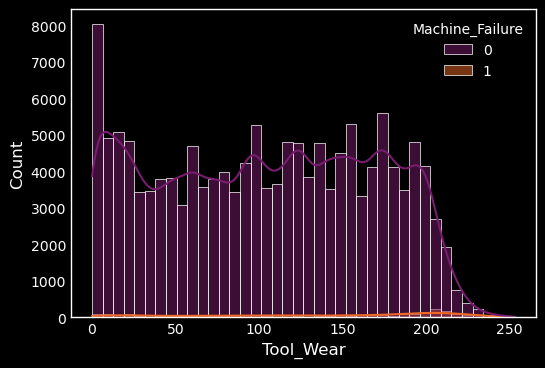

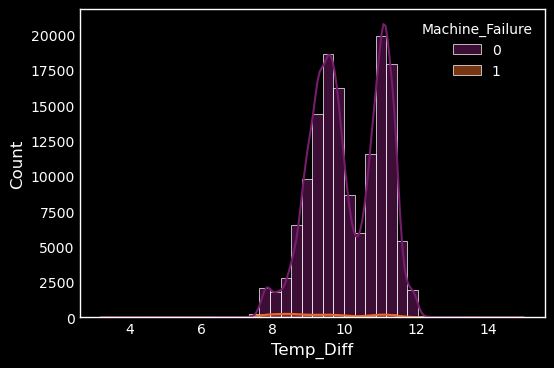

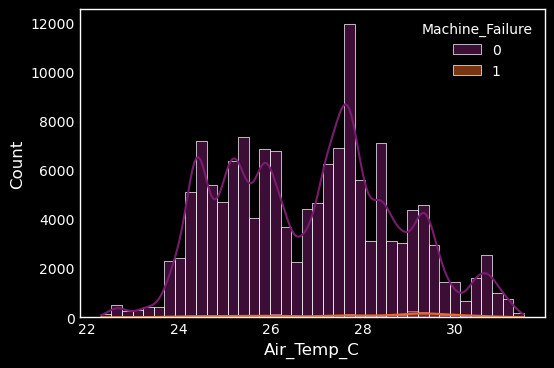

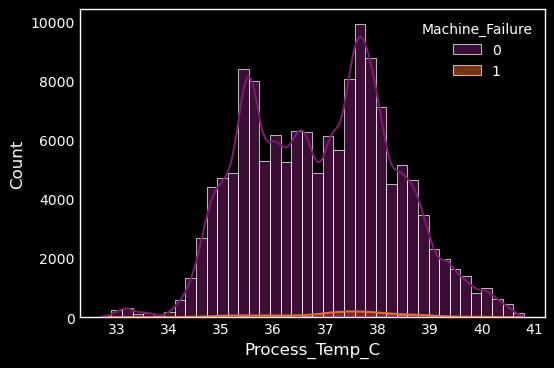

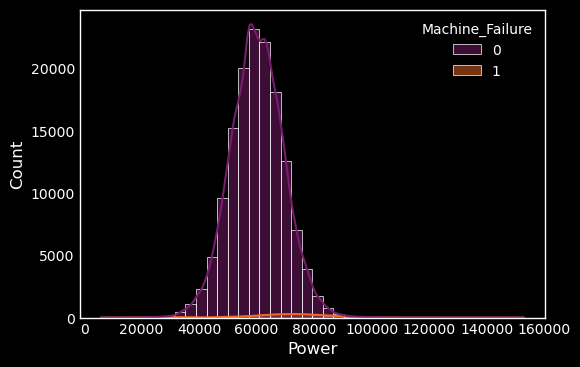

In [83]:
plotCols = [i for i in machine_data.columns if len(machine_data[i].unique())>3]

for i in plotCols:
    plt.figure(figsize=(6,4))
    sns.histplot(machine_data,x =i,hue="Machine_Failure",bins=40,kde=True,palette="inferno")
    plt.show();

# Training Model

** XGB Parameters Defaults**
-  max_depth=3
-  learning_rate=0.1
-  n_estimators=100
-  silent=True
-  objectives = {*binary:logistic*, reg:linear, reg:logistic, binary:logistic, binary:logitraw, count:poisson, multi:softmax, multi:softprob, rank:pairwise}
-  eval_metric = {rmse, logloss, error, merror, mlogloss, auc, ndcg, map}
-  booster= {*gbtree*, gblinear}
-  n_jobs=1
-  nthread=None
-  gamma=0
-  min_child_weight=1
-  max_delta_step=0
-  subsample=1
-  colsample_bytree=1
-  colsample_bylevel=1
-  reg_alpha=0
-  reg_lambda=1
-  scale_pos_weight=1
-  base_score=0.5
-  random_state=0
-  seed=None
-  missing=None

In [84]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

In [85]:
cols = [i for i in machine_data.columns if i!="Machine_Failure"]
seed = np.random.seed(0)

X = machine_data[cols]
y = machine_data["Machine_Failure"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=seed)

## 1. Baseline

In [86]:
xgbmodel_base = XGBClassifier(random_state=seed)
xgbmodel_base.fit(X_train,y_train)

print(" - Baseline ROC Area Under Curve of XGB:",roc_auc_score(y_test, xgbmodel_base.predict_proba(X_test)[:,1]))
print("\n - Baseline Accuracy of XGB:",accuracy_score(y_test, xgbmodel_base.predict(X_test)))
print("\n - Baseline Conf Matrix of XGB:\n",confusion_matrix(y_test, xgbmodel_base.predict(X_test)))
print("\n - Baseline Classification Report of XGB:\n",classification_report(y_test, xgbmodel_base.predict(X_test)))

 - Baseline ROC Area Under Curve of XGB: 0.9605654521238431

 - Baseline Accuracy of XGB: 0.9960664335664335

 - Baseline Conf Matrix of XGB:
 [[35969    17]
 [  127   495]]

 - Baseline Classification Report of XGB:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     35986
           1       0.97      0.80      0.87       622

    accuracy                           1.00     36608
   macro avg       0.98      0.90      0.94     36608
weighted avg       1.00      1.00      1.00     36608



## 2. Manual Tuning

In [87]:
xgbmodel_manual = XGBClassifier(n_estimators=200,learning_rate=1.1,random_state=seed)
xgbmodel_manual.fit(X_train,y_train)

print(" - Baseline ROC Area Under Curve of XGB:",roc_auc_score(y_test, xgbmodel_manual.predict_proba(X_test)[:,1]))
print("\n - Baseline Accuracy of XGB:",accuracy_score(y_test, xgbmodel_manual.predict(X_test)))
print("\n - Baseline Conf Matrix of XGB:\n",confusion_matrix(y_test, xgbmodel_manual.predict(X_test)))
print("\n - Baseline Classification Report of XGB:\n",classification_report(y_test, xgbmodel_manual.predict(X_test)))

 - Baseline ROC Area Under Curve of XGB: 0.9549077722794306

 - Baseline Accuracy of XGB: 0.9951923076923077

 - Baseline Conf Matrix of XGB:
 [[35946    40]
 [  136   486]]

 - Baseline Classification Report of XGB:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     35986
           1       0.92      0.78      0.85       622

    accuracy                           1.00     36608
   macro avg       0.96      0.89      0.92     36608
weighted avg       1.00      1.00      0.99     36608



## 2. GridSearchCV

## 3. RandomizedSearchCV 